Time 17.29 s, object 9 moving at 0.41 m/s toward 138°
Time 17.46 s, object 9 moving at 0.47 m/s toward 137°
Time 17.64 s, object 9 moving at 0.42 m/s toward 135°
Time 17.79 s, object 9 moving at 0.4 m/s toward 132°
Time 17.96 s, object 9 moving at 0.32 m/s toward 129°
Time 18.13 s, object 9 moving at 0.35 m/s toward 126°
Time 18.3 s, object 9 moving at 0.45 m/s toward 130°
Time 18.46 s, object 9 moving at 0.55 m/s toward 131°
Time 18.63 s, object 9 moving at 0.61 m/s toward 130°
Time 18.79 s, object 9 moving at 0.57 m/s toward 128°
Time 18.96 s, object 9 moving at 0.5 m/s toward 126°
Time 19.12 s, object 9 moving at 0.41 m/s toward 128°
Time 19.29 s, object 9 moving at 0.45 m/s toward 127°
Time 19.46 s, object 9 moving at 0.56 m/s toward 132°
Time 19.63 s, object 9 moving at 0.6 m/s toward 132°
Time 19.79 s, object 9 moving at 0.62 m/s toward 132°
Time 19.96 s, object 9 moving at 0.49 m/s toward 128°
Time 20.13 s, object 9 moving at 0.36 m/s toward 112°
[[15.628461624], [15.791964026],

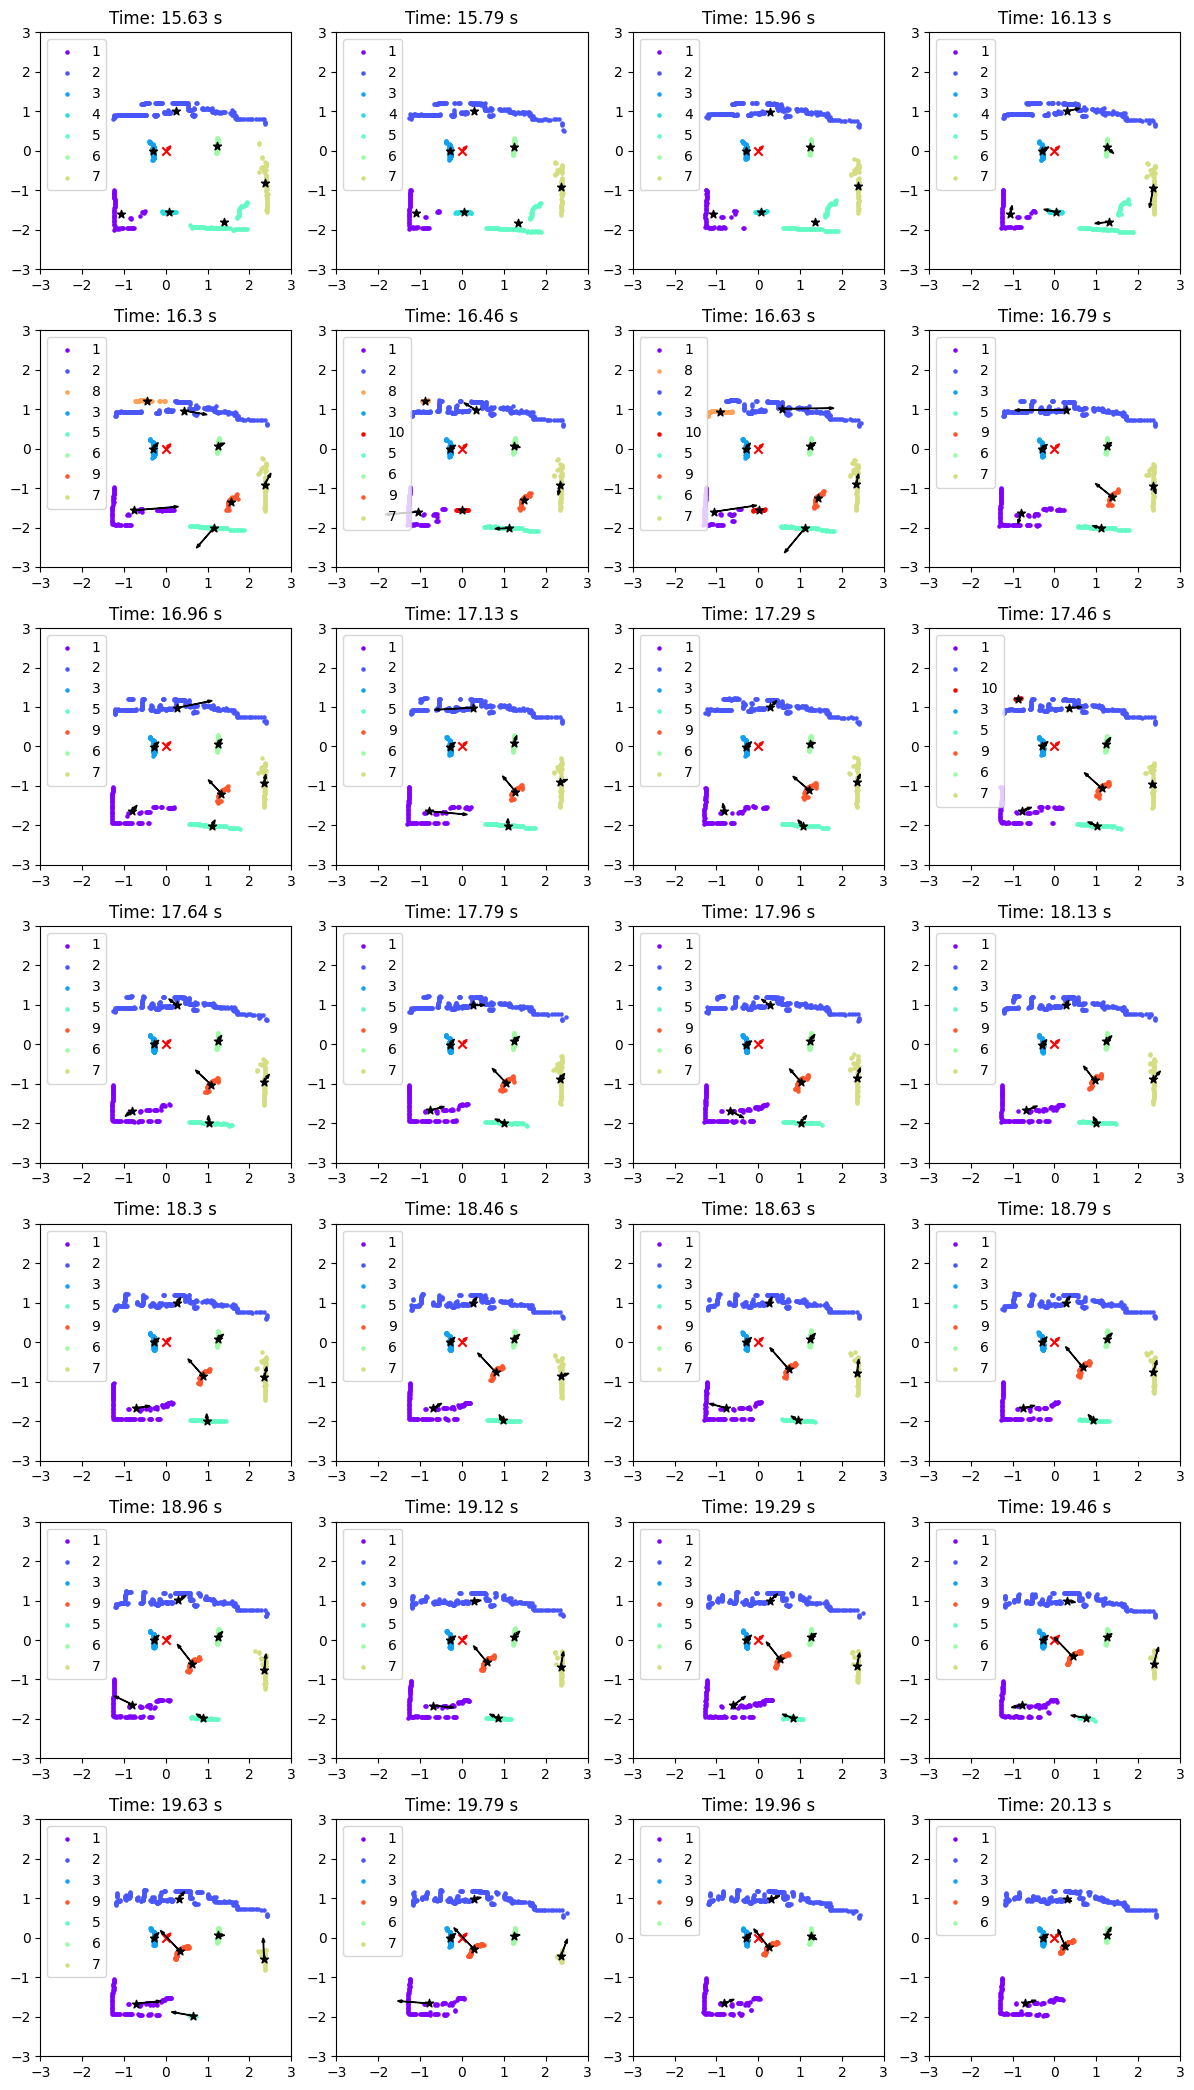

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import math
import numpy as np

COMPONENT_SIZE = 30
COMPONENT_THRESH = 5
MAX_RANGE = 3
NUM_ITERATIONS = 10
MAX_DISPLACEMENT = 3
MAX_SEGMENTS = 10
INTERPOLATION_DIST = 0.05
VEL_THRESH = 0.1
RAW_DATA = open('cleaned.txt', 'r').readlines()[84:112]
RAW_VEL = [(0.05, 0.05)] * len(RAW_DATA)

figure, axis = plt.subplots(len(RAW_DATA) // 4, 4, figsize=(12, 21))
color_options = cm.rainbow(np.linspace(0, 1, MAX_SEGMENTS))
current_frame = []
prev_frame = []
prev_vel = []
frame_count = 0
movements = []

def LagrangeInterpolate(pointList, x):
    sum = 0
    for j in range(len(pointList)):
        value = 1
        for k in range(len(pointList)):
            if k != j:
                value *= (x - pointList[k][0]) / (pointList[j][0] - pointList[k][0])
        sum += pointList[j][1] * value
    return sum

for next in RAW_DATA:
    current_frame = [float(next.replace(' ', ',').split(',')[1]), [0, 0, 0, [], []]]
    stripped = next.replace('\n', ' ').replace('(', ' ').replace(')', ' ').replace('[', ' ').replace(']', ' ').replace(':', ',').replace(' ', '').split(',')[2:]
    points = [[float(stripped[2 * i]), float(stripped[2 * i + 1])] for i in range(int(len(stripped) / 2)) if abs(float(stripped[2 * i])) < MAX_RANGE and abs(float(stripped[2 * i + 1])) < MAX_RANGE]
    grid = [[0 for i in range(COMPONENT_SIZE)] for j in range(COMPONENT_SIZE)]
    components = []
    for i in points:
        a, b = [int(math.floor(j / ((2 * MAX_RANGE) / COMPONENT_SIZE)) + COMPONENT_SIZE / 2) for j in i]
        grid[a][b] -= 1
        if grid[a][b] == -COMPONENT_THRESH:
            components.append((a, b))
    components.sort()
    label = 1
    for (a, b) in components:
        if grid[a][b] >= 0:
            continue
        neighbors = [(a, b)]
        index = 0
        while index < len(neighbors):
            (i, j) = neighbors[index]
            index += 1
            if grid[i][j] >= 0:
                continue
            neighbors.extend([(i - 1, j)] if i > 0 and grid[i - 1][j] <= 0 else [])
            neighbors.extend([(i - 1, j - 1)] if i > 0 and j > 0 and grid[i - 1][j - 1] <= 0 else [])
            neighbors.extend([(i - 1, j + 1)] if i > 0 and j < COMPONENT_SIZE - 1 and grid[i - 1][j + 1] <= 0 else [])
            neighbors.extend([(i, j + 1)] if j < COMPONENT_SIZE - 1 and grid[i][j + 1] <= 0 else [])
            neighbors.extend([(i, j - 1)] if j > 0 and grid[i][j - 1] <= 0 else [])
            neighbors.extend([(i + 1, j)] if i < COMPONENT_SIZE - 1 and grid[i + 1][j] <= 0 else [])
            neighbors.extend([(i + 1, j - 1)] if i < COMPONENT_SIZE - 1 and j > 0 and grid[i + 1][j-1] <= 0 else [])
            neighbors.extend([(i + 1, j + 1)] if i < COMPONENT_SIZE - 1 and j < COMPONENT_SIZE - 1 and grid[i + 1][j + 1] <= 0 else [])
            grid[i][j] = label
        current_frame.append([label, 0, 0, [], []])
        label += 1
    for i in points:
        a, b = [int(math.floor(j / ((2 * MAX_RANGE) / COMPONENT_SIZE)) + COMPONENT_SIZE / 2) for j in i]
        current_frame[max(grid[a][b], 0) + 1][3].append(i[0])
        current_frame[max(grid[a][b], 0) + 1][4].append(i[1])
    for i in range(2, len(current_frame)):
        current_frame[i][1], current_frame[i][2] = [sum(j) / len(j) for j in current_frame[i][3:]]
    if frame_count >= 1:
        old = [(i[1], i[2], i[0]) for i in prev_frame[0][2:]]
        new = [(i[1], i[2], i[0]) for i in current_frame[2:]]
        for i in range(NUM_ITERATIONS):
            for j in old:
                for k in new:
                    if (k[0] - j[0]) ** 2 + (k[1] - j[1]) ** 2 <= (MAX_DISPLACEMENT * (2 * MAX_RANGE) / COMPONENT_SIZE * i / NUM_ITERATIONS) ** 2:
                        old.remove(j)
                        new.remove(k)
                        current_frame[k[2] + 1][0] = j[2]
                        break
        new_max = max([j[0] for j in prev_frame[0][2:]]) + 1
        for i in new:
            current_frame[i[2] + 1][0] = new_max
            new_max += 1
    axis[frame_count // 4, frame_count % 4].scatter(current_frame[1][3], current_frame[1][4], color='white')
    for i in range(2, len(current_frame)):
        axis[frame_count // 4, frame_count % 4].scatter(current_frame[i][3], current_frame[i][4], color=color_options[current_frame[i][0] - 1], s=5, label=current_frame[i][0])
        axis[frame_count // 4, frame_count % 4].scatter(current_frame[i][1], current_frame[i][2], color='black', marker='*')
    axis[frame_count // 4, frame_count % 4].scatter(0, 0, color='red', marker='x')
    axis[frame_count // 4, frame_count % 4].arrow(0, 0, RAW_VEL[frame_count][0], RAW_VEL[frame_count][1], color='red', width=0.01, head_width=0.07)
    movements.append([current_frame[0]])
    if len(prev_frame) == 3:
        current_vel = []
        for i in current_frame[2:]:
            if i[0] in [j[0] for j in prev_frame[0][1:]] and i[0] in [j[0] for j in prev_frame[1][1:]] and i[0] in [j[0] for j in prev_frame[2][1:]]:
                points_x, points_y = [[(k[0],k[[j for j in range(1, len(k)) if k[j][0] == i[0]][0]][p]) for k in prev_frame] + [(current_frame[0], i[p])] for p in range(1, 3)] 
                points_x.sort()
                points_y.sort()
                v_x = (LagrangeInterpolate(points_x, points_x[3][0] + INTERPOLATION_DIST) - LagrangeInterpolate(points_x, points_x[0][0] - INTERPOLATION_DIST))/(points_x[3][0] - points_x[0][0] + 2 * INTERPOLATION_DIST)
                v_y = (LagrangeInterpolate(points_y, points_y[3][0] + INTERPOLATION_DIST) - LagrangeInterpolate(points_y, points_y[0][0] - INTERPOLATION_DIST))/(points_y[3][0] - points_y[0][0] + 2 * INTERPOLATION_DIST)
                v_x += RAW_VEL[frame_count][0]
                v_y += RAW_VEL[frame_count][1]
                axis[frame_count // 4, frame_count % 4].arrow(points_x[3][1], points_y[3][1], v_x, v_y, color='black', width=0.01, head_width=0.07)
                current_vel.append((i[0], v_x, v_y))
                if len(prev_vel) == 3:
                    if i[0] in [j[0] for j in prev_vel[0]] and i[0] in [j[0] for j in prev_vel[1]] and i[0] in [j[0] for j in prev_vel[2]]:
                        works = True
                        for j in range(3):
                            a, b = [prev_vel[j][[k for k in range(len(prev_vel[j])) if prev_vel[j][k][0] == i[0]][0]][p] for p in range(1, 3)]
                            if a * v_x + b * v_y < VEL_THRESH:
                                works = False
                                break
                        if works:
                            movements[len(movements) - 1].append((i[0], round((v_x ** 2 + v_y ** 2) ** 0.5, 2),  round((math.degrees(math.atan2(v_y, v_x)) + 360) % 360)))
                            print(f'Time {round(current_frame[0], 2)} s, object {i[0]} moving at {round((v_x ** 2 + v_y ** 2) ** 0.5, 2)} m/s toward {round((math.degrees(math.atan2(v_y, v_x)) + 360) % 360)}°')
        prev_vel = [current_vel] + prev_vel[:2]
    axis[frame_count // 4, frame_count % 4].set_xlim(-MAX_RANGE, MAX_RANGE)
    axis[frame_count // 4, frame_count % 4].set_ylim(-MAX_RANGE, MAX_RANGE)
    axis[frame_count // 4, frame_count % 4].set_title(f'Time: {round(current_frame[0], 2)} s')
    axis[frame_count // 4, frame_count % 4].legend()
    prev_frame = [[current_frame[0]] + [i[:3] for i in current_frame[1:]]] + prev_frame[:2]
    frame_count += 1
print(movements)
plt.tight_layout()
plt.savefig('detection_while_moving.png')
plt.show()